# ogbg-molhiv-smiles

This notebook try to convert the `ogbg-molhiv` to the `smiles` formate of the graphs.

Let's make it clear what is `smiles` and what is `ogbg-molhiv`.
- `ogbg-molhiv`: It is a molecular graph dataset which is standardized for benchmarking the results on the graph formate of the molecular data.
- `smiles`: It is the unique string representation of the molecules.

Also, to be on the same page, our goal on this project is to do the classification task on the graph representation of the moleculs.

## Step 1: Download and Load the dataset

Using `PygGraphPropPredDataset` class to download the dataset

In [1]:
from ogb.graphproppred import GraphPropPredDataset, PygGraphPropPredDataset

dataset_name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name=dataset_name, root='../dataset')

### 1.1: Check Dataset Info
Check basic dataset information using `PyG`

In [2]:
print(f"len(dataset): {len(dataset)} <- number of graphs")
print(f"dataset.num_classes: {dataset.num_classes} <- number of labels for classes")
print(
    f"dataset.num_node_features: {dataset.num_node_features} <- number of features for each node of graphs"
)
print(
    f"dataset.num_edge_features: {dataset.num_edge_features} <- number of features for each edge of graphs"
)

len(dataset): 41127 <- number of graphs
dataset.num_classes: 2 <- number of labels for classes
dataset.num_node_features: 9 <- number of features for each node of graphs
dataset.num_edge_features: 3 <- number of features for each edge of graphs


### 1.2 Check Graph Info
Check basic graph information using `PyG`

In [3]:
from tabulate import tabulate
from torch_geometric.data import Data

graph_number = 0
graph: Data = dataset[graph_number]

table = [
    ["Graph #", graph_number],
    ["Graph Object", graph],
    ["", ""],
    ["graph.num_nodes", graph.num_nodes],
    ["graph.num_edges", graph.num_edges],
    ["graph.has_isolated_nodes", graph.has_isolated_nodes()],
    ["graph.has_self_loops", graph.has_self_loops()],
    ["graph.is_directed", graph.is_directed()],
    ["graph.x.shape", graph.x.shape],
    ["graph.x", graph.x],
    ["graph.y.shape", graph.y.shape],
    ["graph.y", graph.y],
    ["graph.edge_attr.shape", graph.edge_attr.shape],
    ["graph.edge_attr", graph.edge_attr],
    ["graph.edge_index.shape", graph.edge_index.shape],
    ["graph.edge_index", graph.edge_index],
]

print(tabulate(table, headers=["Property", "Value"], tablefmt="grid"))


+--------------------------+----------------------------------------------------------------------------------+
| Property                 | Value                                                                            |
+==========================+==================================================================================+
| Graph #                  | 0                                                                                |
+--------------------------+----------------------------------------------------------------------------------+
| Graph Object             | Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)   |
+--------------------------+----------------------------------------------------------------------------------+
+--------------------------+----------------------------------------------------------------------------------+
| graph.num_nodes          | 19                                                                         

### 1.3 Dataset Scaffolded Split
Using `PyG` scaffolded splited dataset we have pre-defined __train__, __validation__ and __test__ sub-datasets.

In [4]:
train_idxes = dataset.get_idx_split().get('train')
valid_idxes = dataset.get_idx_split().get('valid')
test_idxes = dataset.get_idx_split().get('test')
train_pyg_graphs = [dataset[i] for i in train_idxes]
valid_pyg_graphs = [dataset[i] for i in valid_idxes]
test_pyg_graphs = [dataset[i] for i in test_idxes]

In [5]:
total_size = len(train_pyg_graphs) + len(valid_pyg_graphs) + len(test_pyg_graphs)
train_percentage = (len(train_pyg_graphs) / total_size) * 100
valid_percentage = (len(valid_pyg_graphs) / total_size) * 100
test_percentage = (len(test_pyg_graphs) / total_size) * 100

table = [
    ["Dataset", "Size", "Percentage"],
    ["Train", len(train_pyg_graphs), f"{train_percentage:.2f}%"],
    ["Validation", len(valid_pyg_graphs), f"{valid_percentage:.2f}%"],
    ["Test", len(test_pyg_graphs), f"{test_percentage:.2f}%"]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+------------+--------+--------------+
| Dataset    |   Size | Percentage   |
+============+========+==============+
| Train      |  32901 | 80.00%       |
+------------+--------+--------------+
| Validation |   4113 | 10.00%       |
+------------+--------+--------------+
| Test       |   4113 | 10.00%       |
+------------+--------+--------------+


## Step 2: Convert `pyg` graphs to `networkx` graphs

Using our helper function `pyg_to_networkx()`, we make also the `networkx` graphs version of the dataset. 

In [6]:
import sys
sys.path.append('..')  # Add parent directory to Python path

from utils.utils import pyg_to_networkx

train_nx_graphs = [pyg_to_networkx(i) for i in train_pyg_graphs]
valid_nx_graphs = [pyg_to_networkx(i) for i in valid_pyg_graphs]
test_nx_graphs = [pyg_to_networkx(i) for i in test_pyg_graphs]

## Step 3: Get `SMILES` version of graphs

Using the secondary dataset, we get and concate the `SMILES` or string version of the graphs. 

In [7]:
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Lipinski import *
from rdkit.Chem.AtomPairs import Torsions, Pairs
from rdkit.Chem import MACCSkeys 
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem import MACCSkeys 
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from tqdm import tqdm
from ogb.graphproppred import GraphPropPredDataset
from tqdm import tqdm

smile_data = pd.read_csv(f"../dataset/ogbg_molhiv/mapping/mol.csv.gz".replace("-", "_"))
smile_data.drop(["mol_id"], axis = 1, inplace=True)
mol = [Chem.MolFromSmiles(x) for x in tqdm(smile_data.smiles)]
smile_data['mol'] = mol
train_dataset = smile_data.iloc[train_idxes]
train_dataset['nx_graph'] = train_nx_graphs
train_dataset['pyg_graph'] = train_pyg_graphs
train_dataset['num_nodes'] = train_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
train_dataset['num_edges'] = train_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)
valid_dataset = smile_data.iloc[valid_idxes]
valid_dataset['nx_graph'] = valid_nx_graphs
valid_dataset['pyg_graph'] = valid_pyg_graphs
valid_dataset['num_nodes'] = valid_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
valid_dataset['num_edges'] = valid_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)
test_dataset = smile_data.iloc[test_idxes]
test_dataset['nx_graph'] = test_nx_graphs
test_dataset['pyg_graph'] = test_pyg_graphs
test_dataset['num_nodes'] = test_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_nodes)
test_dataset['num_edges'] = test_dataset['pyg_graph'].apply(lambda pyg_graph: pyg_graph.num_edges)


 85%|████████▍ | 34883/41127 [00:06<00:01, 5245.00it/s][17:41:57] WARNING: not removing hydrogen atom without neighbors
[17:41:57] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41127/41127 [00:07<00:00, 5471.52it/s]


In [8]:
train_dataset.head()

,HIV_active,smiles,mol,nx_graph,pyg_graph,num_nodes,num_edges
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",24,50
4,0,O=S(=O)(O)CCS(=O)(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 1, 4,...",10,18
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",16,32
6,0,O=C(O)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 3, 4,...",10,20
8,0,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,...",26,54


There is good visualization of the `Molecules` in `rdkit` library.

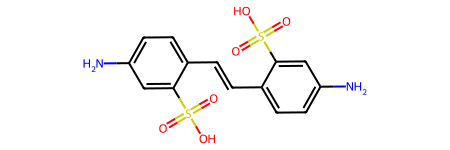

In [9]:
train_dataset.iloc[0].mol

## Step 4: Extract `Molecular` Features from the `SMILE` string

### 4.1: Morgan Fingerprint


In [10]:
def morgan_fp(mol):
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol ,radius = 3, nBits=3*1024), dtype= np.int8)

train_dataset['morgan_fp'] = train_dataset['mol'].apply(lambda mol: morgan_fp(mol))
valid_dataset['morgan_fp'] = valid_dataset['mol'].apply(lambda mol: morgan_fp(mol))
test_dataset['morgan_fp'] = test_dataset['mol'].apply(lambda mol: morgan_fp(mol))

### 4.2: RDKit-FP

In [11]:
def rdkit_fp(mol):
    return np.array(Chem.RDKFingerprint(mol, maxPath = 5, bitInfo={}), dtype= np.int8)

train_dataset['rdkit_fp'] = train_dataset['mol'].apply(lambda mol: rdkit_fp(mol))
valid_dataset['rdkit_fp'] = valid_dataset['mol'].apply(lambda mol: rdkit_fp(mol))
test_dataset['rdkit_fp'] = test_dataset['mol'].apply(lambda mol: rdkit_fp(mol))

In [13]:
train_dataset.head()

,HIV_active,smiles,mol,nx_graph,pyg_graph,num_nodes,num_edges,morgan_fp,rdkit_fp
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",24,50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,O=S(=O)(O)CCS(=O)(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 1, 4,...",10,18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,...",16,32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0,O=C(O)c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[(edge_index, [tensor([0, 1, 1, 2, 1, 3, 3, 4,...",10,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,0,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,<rdkit.Chem.rdchem.Mol object at 0x0000025F120...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,...",26,54,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
